<a href="https://colab.research.google.com/github/machiwao/ml-development/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [388]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

!pip install stanza
import stanza

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [389]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [390]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

**Validation Set**

Use this set to evaluate your model

In [391]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [392]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [393]:
# put your answer here
df_train.head(10)

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1
6,Leni Kiko,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1
8,Another reminderHalalan,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0


2. Check how many rows and columns are in the training dataset using `.info()`

In [394]:
# put your answer here
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [395]:
# put your answer here
df_train.isnull().sum()

,0
text,0
label,0


4. Check for duplicate rows

In [396]:
# put your answer here
df_train.duplicated().sum()

0

5. Check how many rows belong to each class

In [397]:
# put your answer here
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [398]:
# put your answer here
df_train.drop_duplicates(inplace = True)

7. Remove rows with NaN values

In [399]:
# put your answer here
df_train.dropna(inplace = True)

8. Convert all text to lowercase

In [400]:
# put your answer here
df_train['text'] = df_train['text'].str.lower()

9. Remove digits, URLS and special characters

In [401]:
# put your answer here
df_train['text'] = df_train['text'].str.replace('[^a-zA-Z]', ' ')
df_train['text'] = df_train['text'].str.replace('http\S+|www.\S+', '', case=False)
df_train['text'] = df_train['text'].str.replace(r'\d+', '')
df_train['text'] = df_train['text'].str.replace(r'[^\w\s]+', '')
df_train['text'] = df_train['text'].str.strip()
df_train['text'] = df_train['text'].str.replace(r'\s+', ' ')
df_train['text'] = df_train['text'].str.replace(r'^\s+', '')
df_train['text'] = df_train['text'].str.replace(r'\s+$', '')

10. Remove stop words

In [402]:
# put your answer here
filipino_stopwords = set([
        'akin', 'aking', 'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano',
        'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'ba', 'bababa', 'bago',
        'bakit', 'bawat', 'bilang', 'dahil', 'dalawa', 'dapat', 'din', 'dito',
        'doon', 'eh', 'gagawin', 'gayunman', 'ginagawa', 'ginawa', 'ginawang',
        'gumawa', 'gusto', 'ha', 'habang', 'hanggang', 'hindi', 'huwag', 'hoy',
        'iba', 'ibaba', 'ibabaw', 'ibig', 'ikaw', 'ilagay', 'ilalim', 'ilan',
        'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyang','iyong', 'ka',
        'kahit', 'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang',
        'kanino', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan',
        'katiyakan', 'katulad', 'kaya', 'kaysa', 'ko', 'kong', 'kulang',
        'kumuha', 'kung', 'laban', 'lahat', 'lamang', 'likod', 'lima', 'maaari',
        'maaaring', 'maging', 'mahusay', 'makita', 'marami', 'marapat',
        'masyado', 'may', 'mayroon', 'mga', 'minsan', 'mismo', 'mula', 'muli', 'na',
        'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'namin', 'nang',
        'napaka', 'narito', 'nasaan', 'ng', 'ngayon', 'ngunit', 'ni', 'nila', 'nilang',
        'nito', 'niya', 'niyang', 'noon', 'o', 'pa', 'paano', 'pababa',
        'paggawa', 'pagitan', 'pagkakaroon', 'pagkatapos', 'pala', 'palabas',
        'pamamagitan', 'panahon', 'pangalawa', 'para', 'paraan', 'pareho',
        'pataas', 'pero', 'po', 'pumunta', 'pumupunta', 'sa', 'saan', 'sabi',
        'sabihin', 'sarili', 'sila', 'sino', 'siya',
        'tatlo', 'tayo', 'tulad', 'tungkol', 'una', 'walang', 'yan', 'yung', 'username'
    ])

english_stopwords = set(stopwords.words('english'))
combined_stopwords = filipino_stopwords.union(english_stopwords)

df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (combined_stopwords)]))

11. Use Stemming or Lemmatization

In [403]:
# put your answer here
lemmatizer = WordNetLemmatizer()
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
'''porter = PorterStemmer()
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))'''

"porter = PorterStemmer()\ndf_train['text'] = df_train['text'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))"

## C. Training your model

12. Put all text training data in variable **X_train**

In [404]:
# put your answer here
X_train = df_train['text']

13. Put all training data labels in variable **y_train**

In [405]:
# put your answer here
y_train = df_train['label']

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [406]:
# put your answer here
'''vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)'''
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)

15. Create an instance of `MultinomalNB()`

In [418]:
# put your answer here
model = MultinomialNB(alpha = 0.5)

16. Train the model using `.fit()`

In [419]:
# put your answer here
model.fit(X_train_transformed, y_train)

MultinomialNB(alpha=0.5)

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [420]:
# put your answer here
X_validation = df_validation['text']
X_validation_transformed = vectorizer.transform(X_validation)
y_validation_pred = model.predict(X_validation_transformed)

18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [421]:
# put your answer here
y_validation = df_validation['label']
print(classification_report(y_validation, y_validation_pred))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1385
           1       0.80      0.86      0.83      1415

    accuracy                           0.82      2800
   macro avg       0.82      0.82      0.82      2800
weighted avg       0.82      0.82      0.82      2800



19. Create a confusion matrix using the **validation dataset**

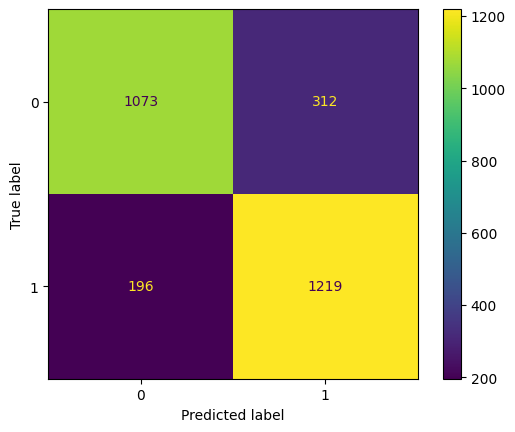

In [422]:
# put your answer here
cm = confusion_matrix(y_validation, y_validation_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [423]:
# put your answer here
X_test = df_test['text']
X_test_transformed = vectorizer.transform(X_test)
y_test_pred = model.predict(X_test_transformed)

21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [424]:
# put your answer here
y_test = df_test['label']
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1412
           1       0.79      0.87      0.83      1398

    accuracy                           0.82      2810
   macro avg       0.82      0.82      0.82      2810
weighted avg       0.82      0.82      0.82      2810



22. Create a confusion matrix using the **test dataset**

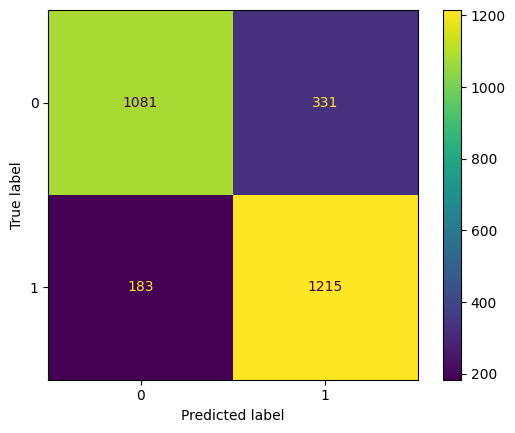

In [425]:
# put your answer here
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [426]:
# put your answer here
input_text = pd.Series("How are you")
input_text_transform = vectorizer.transform(input_text)
prediction = model.predict(input_text_transform)
prediction

array([0])

24. Test the model by providing a hate speech input. The model should predict it as 1

In [427]:
# put your answer here
input_text = pd.Series("BBM")
input_text_transform = vectorizer.transform(input_text)
prediction = model.predict(input_text_transform)
prediction

array([1])

In [428]:
#Challenge
input_text = pd.Series("Ang init ng ulo ko ang gulo gulo ng paligid ang sarap talaga sumigaw ng putangina")
input_text_transform = vectorizer.transform(input_text)
prediction = model.predict(input_text_transform)
prediction

array([1])